# Plot divergence trees with baltic


In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import numpy as np
import json
import pandas as pd
from scipy.special import binom

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [3]:
def load_tree_newick(tree_path):
    tree = bt.loadNewick(tree_path)
    return(tree)

In [4]:
def load_tree_json(tree_path):
    
    with open(tree_path, "r") as json_file:
        tree_json = json.load(json_file)
    tree_object=tree_json['tree']
    meta=tree_json['meta']
    json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['div'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

    tree=bt.loadJSON(tree_object,json_translation)
    
    return(tree)

In [5]:
# read in metadata dictionary
def generate_metadata_dictionary(metadata_path):
    metadata = {}

    with open(metadata_path, "r") as infile: 
        for line in infile: 
            if "isolate_id" not in line:
                strain = line.split("\t")[0].replace("?","_")  #iqtree will do this replacement
                ha_type = line.split("\t")[-1].strip()
                date = line.split("\t")[3]
                if date == "?":
                    date1 = "XXXX-XX-XX"
                else:
                    date1 = date

                metadata[strain] = {"ha_type":ha_type, "date":date1}
    return(metadata)

In [6]:
def plot_full_genome_divergence_tree(tree,metadata,colors,vaccines, ha_order, vax_distances, output_name, width, height):
    fig,ax = plt.subplots(figsize=(width, height),facecolor='w')

    divergence = [0,0.2,0.4,0.6,0.8]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=1.25 ## default branch width
    tipSize = 40
    labelSize = 10
    print(tree.ySpan)

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        y=k.y ## or use absolute time instead
        x=k.absoluteTime
        
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.absoluteTime ## get x position of current object's parent
        else:
            xp = x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
            
            strain = k.numName
            ha_type = metadata[strain]['ha_type']
            c=colors[ha_type]
            
            s=tipSize 
            m = "."
            z=11
            label_text = ""
            c=colors[ha_type]
            label_position = k.absoluteTime, k.y
            
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',marker=m,zorder=z) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',marker=m,zorder=10) ## plot black circle underneath
        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


    """now, go back and plot the x's"""
    for k in tree.Objects: ## iterate over objects in tree
        y=k.y ## or use absolute time instead
        x=k.absoluteTime
        
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.absoluteTime ## get x position of current object's parent
        else:
            xp = x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            strain = k.numName
            ha_type = metadata[strain]['ha_type']
            
            if strain in vaccines:
                s = tipSize*3
                m = "X"
                c="black"
                z=12
                label_text = k.numName.title() + " (" + ha_type.upper() + ")"
                label_position = k.absoluteTime + vax_distances[strain]["x"], k.y + vax_distances[strain]["y"]
            
                # plot tthe X's with labels
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',marker=m,zorder=z) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',marker=m,zorder=z) ## plot black circle underneath
                ax.text(x,y,position=label_position,s=label_text,size=labelSize,zorder=13)
            else:
                pass
        else:
            pass
    
    
    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
    for ha_type in ha_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[ha_type], marker='o', markerfacecolor = colors[ha_type], label = ha_type.replace("_"," ").upper(), markersize = 6)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    #ax.set_xlim(0,0.0125)
    ax.set_ylim(-5,tree.ySpan+15)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticks(divergence)
    plt.xlabel("Divergence", fontsize=16)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.15, 0.0], loc=3,prop={'size': 12}, facecolor='w')

    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name, bbox_inches="tight")

    plt.show()

In [7]:
def plot_full_genome_divergence_tree_flu_b(tree,metadata,colors,vaccines, ha_order, vax_distances, output_name, width, height):
    fig,ax = plt.subplots(figsize=(width, height),facecolor='w')

    divergence = [0,0.03,0.06,0.09,0.12,0.15]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in divergence]

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    branchWidth=1.25 ## default branch width
    tipSize = 40
    labelSize = 10
    print(tree.ySpan)

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        y=k.y ## or use absolute time instead
        x=k.absoluteTime
        
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.absoluteTime ## get x position of current object's parent
        else:
            xp = x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            #x=decimalDate(k.name.split('_')[-1],variable=True) ## get x position from name
            
            strain = k.numName
            ha_type = metadata[strain]['ha_type']
            c=colors[ha_type]
            
            s=tipSize 
            m = "."
            z=11
            label_text = ""
            c=colors[ha_type]
            label_position = k.absoluteTime, k.y
            
            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',marker=m,zorder=z) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',marker=m,zorder=10) ## plot black circle underneath
        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            c="#696969"
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []


    """now, go back and plot the x's"""
    for k in tree.Objects: ## iterate over objects in tree
        y=k.y ## or use absolute time instead
        x=k.absoluteTime
        
        
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if 'node_attrs' in k.parent.traits:
            xp=k.parent.absoluteTime ## get x position of current object's parent
        else:
            xp = x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            strain = k.numName
            ha_type = metadata[strain]['ha_type']
            
            if strain in vaccines:
                s = tipSize*3
                m = "X"
                c="black"
                z=12
                label_text = k.numName.title() + " (" + ha_type.title() + ")"
                label_position = k.absoluteTime + vax_distances[strain]["x"], k.y + vax_distances[strain]["y"]
            
                # plot tthe X's with labels
                ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',marker=m,zorder=z) ## plot circle for every tip
                ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',marker=m,zorder=z) ## plot black circle underneath
                ax.text(x,y,position=label_position,s=label_text,size=labelSize,zorder=13)
            else:
                pass
        else:
            pass
    
    
    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    #ax.legend(handles = han_list, markerfirst = True, frameon=False, bbox_to_anchor=[0.8, 1], loc=2, prop={'size': 24})
    for ha_type in ha_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[ha_type], marker='o', markerfacecolor = colors[ha_type], label = ha_type.replace("_"," ").replace("yam","Yamagata lineage").replace("vic","Victoria lineage"), markersize = 6)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    #ax.set_xlim(0,0.0125)
    ax.set_ylim(-5,tree.ySpan+15)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_yticklabels([])
    ax.set_xticks(divergence)
    plt.xlabel("Divergence", fontsize=16)

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.0, 0.05], loc=3,prop={'size': 12}, facecolor='w')

    plt.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(output_name, bbox_inches="tight")

# Run 

In Figtree, I manually rooted the tree (midpoint) and ordered the nodes to be in descending order. Then, export as newick and check "export as displayed" or something like that. 

In [23]:
# try instead, clustering into regions and plotting it that way; we could do: west, 2 midwests, 2 souths, northeast
group_2_ha = ["h3","h4","h7","h10","h14","h15"]
group_1_ha = ["h1","h2","h5","h6","h8","h9","h11","h12","h13","h16","h17","h18"]
flu_b_order = ["vic","yam"]
all_ha_order = ["h1","h2","h3","h4","h5","h6","h7","h8","h9","h10","h11","h12","h13","h14","h15","h16","h17","h18"]

# colors_group2 = {"h3":"#EEA160",
#           "h4":"#93B2D2",
#           "h7":"#5CA7A4",
#           "h10":"#695B82",
#           "h14":"#C5656E", #"#2664A5",
#           "h15":"#F9E7C3", #"#CF7E86",
#           "h1":"#B2313D",
#          "":"#000000"}

colors_group2 = {"h3":"#438B62",
          "h4":"#EEA160",
          "h7":"#F9E7C3",
          "h10":"#2664A5",
          "h14":"#695B82", #"#2664A5",
          "h15":"#B2313D",    
         "":"#000000"}


colors_group1 = {"h1":"#B0DBC2",
          "h2":"#93B2D2",
          "h5":"#5CA7A4",
          "h6":"#695B82",
          "h8":"#C5656E", #"#2664A5",
          "h9":"#438B62",    
          "h11":"#B2313D", 
          "h12":"#EEA160",
          "h13":"#2664A5",
          "h16":"#F9E7C3", #"#CF7E86",
          "h17":"#2D1E45",
          "h18":"#EEC060",
         "":"#000000"}

colors_flub = {"vic":"#C5656E", "yam":"#2664A5"}

colors = {"h1":"#B2313D",
          "h2":"#695B82",
        "h3":"#2664A5",
          "h4":"#93B2D2",
          "h5":"#C5656E",
          "h6":"#F9E7C3",
          "h7":"#5CA7A4",
          "h8":"#B3C8BC",
          "h9": "#742028",
          "h10":"#544370",
          "h11":"#EEA160",
          "h12":"#EEA160",
          "h13":"#EEA160",
          "h14":"#EEA160",
          "h15":"#CF7E86",
          "h16":"#EEA160",
          "h17":"#EEA160",
          "h18":"#EEA160",
          "":"#000000"}


uncertainty_color = "#B9B9B9"

vaccines = ["A/Michigan/45/2015","a/japan/305/1957","A/Singapore/INFIMH-16-0019/2016","a/duck/czech/1956",
       "A/Vietnam/1203/2004","a/taiwan/2/2013","A/Shanghai/2/2013","a/mallard/sweden/24/2002",
       "A/HongKong/33982/2009","a/jiangxi/09037/2014","A/shoveler/netherlands/18/1999",
       "a/mallard/interior_alaska/7mp0167/2007","a/shorebird/delaware/68/2004","a/mallard/gurjev/263/1982",
       "a/shearwater/west_australia/2576/1979","a/black-headed_gull/sweden/5/99",
       "a/little_yellow-shouldered_bat/guatemala/060/2010","a/flat_faced_bat/peru/033/2010",
           "B/Colorado/6/2017", "B/Phuket/3073/2013"]

vax_distances = {"A/Shanghai/2/2013":{"x":0.05,"y":-14},"a/shearwater/west_australia/2576/1979": {"x":0.04,"y":0}, 
                  "a/jiangxi/09037/2014":{"x":0.04,"y":-2},"A/Singapore/INFIMH-16-0019/2016":{"x":0.02,"y":-2},
                 "a/mallard/gurjev/263/1982":{"x":0.06,"y":0},"a/duck/czech/1956":{"x":0.08,"y":-2},
                
                "A/shoveler/netherlands/18/1999":{"x":0.07,"y":-11}, "a/black-headed_gull/sweden/5/99":{"x":0.05,"y":0},
                "a/shorebird/delaware/68/2004":{"x":0.12, "y":-7}, "A/HongKong/33982/2009":{"x":0.1,"y":-5},
                "a/mallard/sweden/24/2002":{"x":0.06,"y":-6},"a/mallard/interior_alaska/7mp0167/2007":{"x":0.05,"y":-9},
                "a/little_yellow-shouldered_bat/guatemala/060/2010":{"x":0.03,"y":-75},
                 "a/flat_faced_bat/peru/033/2010":{"x":0.045,"y":-35},
                "a/taiwan/2/2013":{"x":0.03,"y":-12}, "A/Michigan/45/2015":{"x":0.03,"y":-5},
                "A/Vietnam/1203/2004":{"x":0.07,"y":8}, "a/japan/305/1957":{"x":0.07,"y":-30}, 
                
                "B/Colorado/6/2017":{"x":0.01,"y":-5}, "B/Phuket/3073/2013":{"x":0.01,"y":-5}}

In [12]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))


Tree height: 0.542604
Tree length: 10.301235
annotations present

Numbers of objects in tree: 1868 (874 nodes and 994 leaves)

994


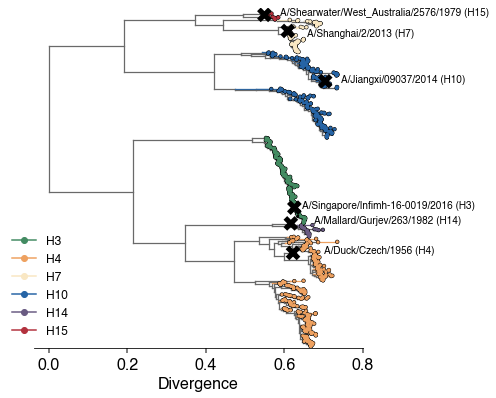

In [61]:
# run for the full genome tree first 

# group 2 ha
tree_path_newick = "../results/tree-raw_group_2_ha.nwk"
tree_path_json = "../auspice/flu_group_2_ha.json"
metadata_path = "../results/metadata_group_2_ha.tsv"
ha_order = group_2_ha
colors = colors_group2
output_name = "group-2-ha-divergence-tree-"+current_date+".pdf"
width = 6
height = 6

tree = load_tree_json(tree_path_json)
tree.traverse_tree() ## required to set heights

metadata = generate_metadata_dictionary(metadata_path)
plot_full_genome_divergence_tree(tree,metadata,colors,vaccines,ha_order,vax_distances,output_name, width, height)


Tree height: 0.748098
Tree length: 27.499593
annotations present

Numbers of objects in tree: 4363 (2085 nodes and 2278 leaves)

2278


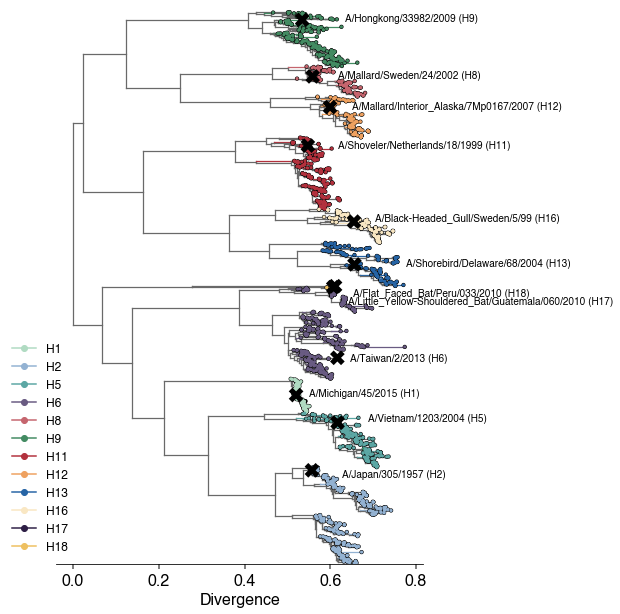

In [24]:
# group 1 ha
tree_path_newick = "../results/tree-raw_group_1_ha.nwk"
tree_path_json = "../auspice/flu_group_1_ha.json"
metadata_path = "../results/metadata_group_1_ha.tsv"
ha_order = group_1_ha
colors = colors_group1
output_name = "group-1-ha-divergence-tree-"+current_date+".pdf"
width = 7
height = 9

tree = load_tree_json(tree_path_json)
tree.traverse_tree() ## required to set heights

metadata = generate_metadata_dictionary(metadata_path)
metadata['a/japan/305_/1957'] = {"ha_type": "h2", "date":"1957-01-01"}

plot_full_genome_divergence_tree(tree,metadata,colors,vaccines,ha_order,vax_distances,output_name, width, height)

In [94]:
metadata['a/japan/305-/1957']

{'ha_type': 'h2', 'date': '1957-01-01'}


Tree height: 0.070021
Tree length: 1.145789
annotations present

Numbers of objects in tree: 900 (410 nodes and 490 leaves)

490


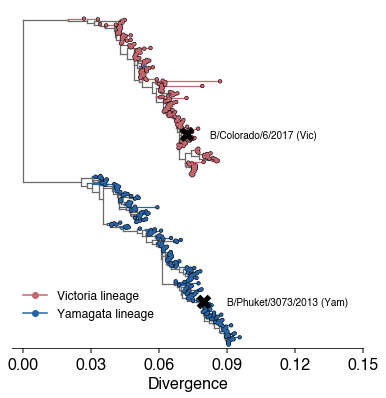

In [10]:
# flu B
tree_path_json = "../auspice/flu_flu_b_ha.json"
metadata_path = "../results/metadata_flu_b_ha.tsv"
ha_order = flu_b_order
colors = colors_flub
output_name = "flu-B-divergence-tree-"+current_date+".pdf"

width = 6
height = 6

tree = load_tree_json(tree_path_json)
tree.traverse_tree() ## required to set heights

metadata = generate_metadata_dictionary(metadata_path)
plot_full_genome_divergence_tree_flu_b(tree,metadata,colors,vaccines,ha_order,vax_distances,output_name, width, height)

In [ ]:


# all subtypes
tree_path_json = "../../one-tree/auspice/flu_avian_ha.json"
metadata_path = "../../one-tree/results/metadata_ha.tsv"
ha_order = all_ha_order
colors = colors_all
output_name = "all-ha-divergence-tree-"+current_date+".pdf"

tree = load_tree_json(tree_path_json)
tree.traverse_tree() ## required to set heights

metadata = generate_metadata_dictionary(metadata_path)
plot_full_genome_divergence_tree(tree,metadata,colors,vaccines,ha_order,vax_distances,output_name, width, height)